### This code is for bonus task 3

- Train a MLP on this binary classification task  
- Compare its performances with a standard machine learning classifier

Let us denote salaries above 30k as 1, and salaries below 30k as 0.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
df_class = pd.read_csv("df_class.csv")
df_class

,year,EdadDesde,EdadHasta,CantidadPuestosVacantes,Confidencial,isco_2dig_pred,num_words,cogn_core,cogn_soph,cogn_comp,...,section_ciiu_J - Information and communication,section_ciiu_K - Financial and insurance activities,section_ciiu_L - Real estate activities,"section_ciiu_M - Professional, scientific and technical activities",section_ciiu_N - Administrative and support service activities,section_ciiu_P - Education,section_ciiu_Q - Human health and social work activities,"section_ciiu_R - Arts, entertainment and recreation",section_ciiu_S - Other service activities,class
0,2023.0,24.0,70.0,1,1.0,33.0,256.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,2023.0,24.0,70.0,1,1.0,33.0,256.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2,2022.0,18.0,40.0,6,0.0,52.0,49.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
3,2022.0,18.0,40.0,6,0.0,52.0,49.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
4,2012.0,18.0,45.0,3,1.0,52.0,45.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28626,2021.0,28.0,40.0,2,1.0,52.0,40.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
28627,2021.0,18.0,45.0,1,1.0,33.0,14.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
28628,2021.0,18.0,46.0,1,1.0,33.0,22.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
28629,2011.0,21.0,40.0,1,0.0,52.0,15.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


Text(0.5, 1.0, 'Class distribution in Sueldo above and below 30k')

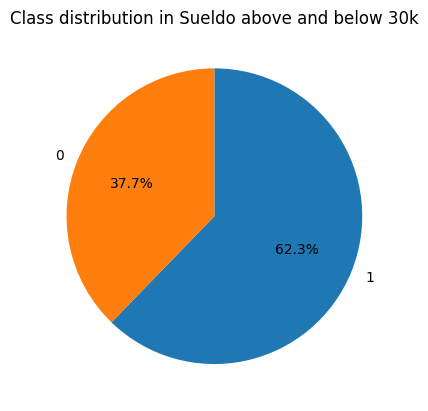

In [53]:
# display pie chart for class of Sueldo
plt.figure()
plt.pie(df_class["class"].value_counts(), labels=df_class["class"].value_counts().index, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title("Class distribution in Sueldo above and below 30k")

## data preprocessing and split

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

# data split 
X = df_class.drop(columns=["class"])
y = df_class["class"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# redefine "continuous_features" because it included "Sueldo", which is target variable 
continuous_features = [col for col in df_class.columns if col != 'class' and df_class[col].dtype != "object"]

# fit scaler only on training set and continous fetures 
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_val_scaled[continuous_features] = scaler.transform(X_val[continuous_features])
X_test_scaled[continuous_features] = scaler.transform(X_test[continuous_features])


# Convert to torch tensors 
def to_tensor(X_df, y_array):
    #X_tensor = torch.tensor(X_df.values, dtype=torch.float32)
    #y_tensor = torch.tensor(y_array, dtype=torch.float32)
    X_tensor = torch.tensor(X_df.values.astype(np.float32)) 
    y_tensor = torch.tensor(y_array.values.astype(np.float32)) 
    return X_tensor, y_tensor

X_train_tensor, y_train_tensor = to_tensor(X_train_scaled, y_train)
X_val_tensor, y_val_tensor = to_tensor(X_val_scaled, y_val)
X_test_tensor, y_test_tensor = to_tensor(X_test_scaled, y_test)

## model training

In [55]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.sparse import vstack
from torchsummary import summary
#from torchinfo import summary

# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define MLP for classification
class MLP_Classifier(nn.Module):
    def __init__(self):
        super(MLP_Classifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], 128),
            nn.ReLU(),
            nn.Dropout(0.3),  
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

model = MLP_Classifier().to(device)


cpu


Epoch: 1, Training Loss: 0.6333, Validation Loss: 0.5553
Epoch: 2, Training Loss: 0.5624, Validation Loss: 0.5365
Epoch: 3, Training Loss: 0.5454, Validation Loss: 0.5253
Epoch: 4, Training Loss: 0.5365, Validation Loss: 0.5226
Epoch: 5, Training Loss: 0.5296, Validation Loss: 0.5200
Epoch: 6, Training Loss: 0.5233, Validation Loss: 0.5180
Epoch: 7, Training Loss: 0.5205, Validation Loss: 0.5156
Epoch: 8, Training Loss: 0.5136, Validation Loss: 0.5132
Epoch: 9, Training Loss: 0.5094, Validation Loss: 0.5100
Epoch: 10, Training Loss: 0.5071, Validation Loss: 0.5076
Epoch: 11, Training Loss: 0.5047, Validation Loss: 0.5098
Epoch: 12, Training Loss: 0.4998, Validation Loss: 0.5086
Epoch: 13, Training Loss: 0.4967, Validation Loss: 0.5095
Epoch: 14, Training Loss: 0.4921, Validation Loss: 0.5086
Epoch: 15, Training Loss: 0.4908, Validation Loss: 0.5077
Epoch: 16, Training Loss: 0.4880, Validation Loss: 0.5080
Epoch: 17, Training Loss: 0.4835, Validation Loss: 0.5275
Epoch: 18, Training Los

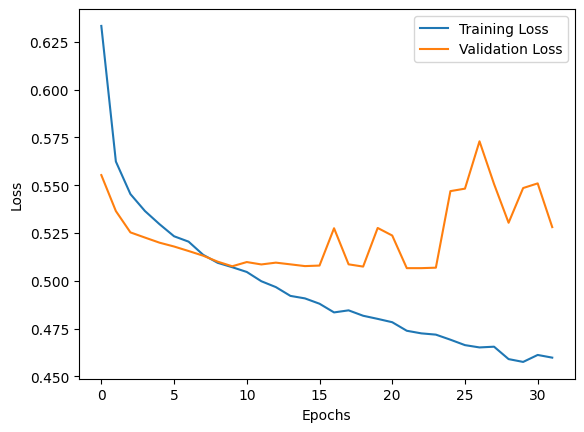

In [56]:
#hyperparameter
lr = 0.0005
batch_size = 128

#training parameters
epochs = 100

#training model function
def train_model(epochs, model, optimizer, criterion, train_loader, val_loader, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.view(-1, 1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target.view(-1, 1))
                val_loss += loss.item()
        val_loss_avg = val_loss / len(val_loader)
        val_losses.append(val_loss_avg)
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')
        
        # Early stopping
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses

# Create TensorDatasets and DataLoaders for Training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Loss Function
#Uncomment to handle class imbalance in the Loss
#class_counts = data_cat['income_>50K'].value_counts().sort_index().values
#class_weights = [sum(class_counts) / c for c in class_counts]
#class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
#criterion = nn.BCELoss(weight=class_weights_tensor[0])
criterion = nn.BCELoss()

# Instantiate optimizer and early stopper
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)


# Run training and plot losses
train_losses, val_losses = train_model(epochs, model, optimizer, criterion, train_loader, test_loader)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Evaluation

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def evaluate_classification_metrics(model, dataloader, threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            probs = output.view(-1).cpu().numpy()
            preds = (probs >= threshold).astype(int)  # Apply threshold to get class label
            targets = target.view(-1).cpu().numpy()

            all_preds.extend(preds)
            all_targets.extend(targets)

    # Convert to NumPy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Compute metrics
    acc = accuracy_score(all_targets, all_preds)
    prec = precision_score(all_targets, all_preds, zero_division=0)
    rec = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)

    print("Validation Metrics:")
    print(f"Accuracy :  {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall   :  {rec:.4f}")
    print(f"F1 Score :  {f1:.4f}")

    return acc, prec, rec, f1

evaluate_classification_metrics(model, val_loader)

Validation Metrics:
Accuracy :  0.7679
Precision:  0.7925
Recall   :  0.8491
F1 Score :  0.8198


(0.7678696158323632,
 0.7924528301886793,
 0.8491201797079745,
 0.8198084221941081)

## Test data

In [54]:
evaluate_classification_metrics(model, test_loader)

Validation Metrics:
Accuracy :  0.7614
Precision:  0.7887
Recall   :  0.8526
F1 Score :  0.8194


(0.7613504074505238,
 0.7887419464225162,
 0.8526392961876833,
 0.8194468909635371)

## Standard machine learning classifier

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# transform from tensor to numpy
X_train_np = X_train_tensor.cpu().numpy()
y_train_np = y_train_tensor.view(-1).cpu().numpy()
X_val_np = X_val_tensor.cpu().numpy()
y_val_np = y_val_tensor.view(-1).cpu().numpy()

# classifiers 
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
}

# evaluation
def evaluate_classic_model(name, model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    acc = accuracy_score(y_val, preds)
    prec = precision_score(y_val, preds, zero_division=0)
    rec = recall_score(y_val, preds, zero_division=0)
    f1 = f1_score(y_val, preds, zero_division=0)

    print(f"\n{name} Metrics:")
    print(f"Accuracy :  {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall   :  {rec:.4f}")
    print(f"F1 Score :  {f1:.4f}")

# output the performance
for name, clf in classifiers.items():
    evaluate_classic_model(name, clf, X_train_np, y_train_np, X_val_np, y_val_np)



Logistic Regression Metrics:
Accuracy :  0.7311
Precision:  0.7656
Recall   :  0.8180
F1 Score :  0.7910

Random Forest Metrics:
Accuracy :  0.8019
Precision:  0.8151
Recall   :  0.8813
F1 Score :  0.8469


The MLP outperformed Logistic Regression, which reached an F1 score of 79.1\%. However, the Random Forest classifier yielded the highest overall performance, achieving an F1 score of 84.7\%, along with superior precision, recall, and accuracy.